In [1]:
import d2lzh as d2l
from mxnet import gluon,init,nd
from mxnet.gluon import nn

# NiN区块
---
- 用1\*1卷积层代替全连层
    - 宽&高 = 样本
    - 通道channels = 特征
- Global Average Pooling
    - 全连接层容易过拟合,往往依赖于dropout等正则化手段
    - 分类任务有多少个类别,就控制最终产生多少个feature map.
    - 对每个feature map的数值求平均作为某类别的置信度,类似FC层输出的特征向量,再经过softmax分类
    - 和传统fully connected layer 的比较：无需拉直每一维，直接输入。且减少了很多的参数
  
   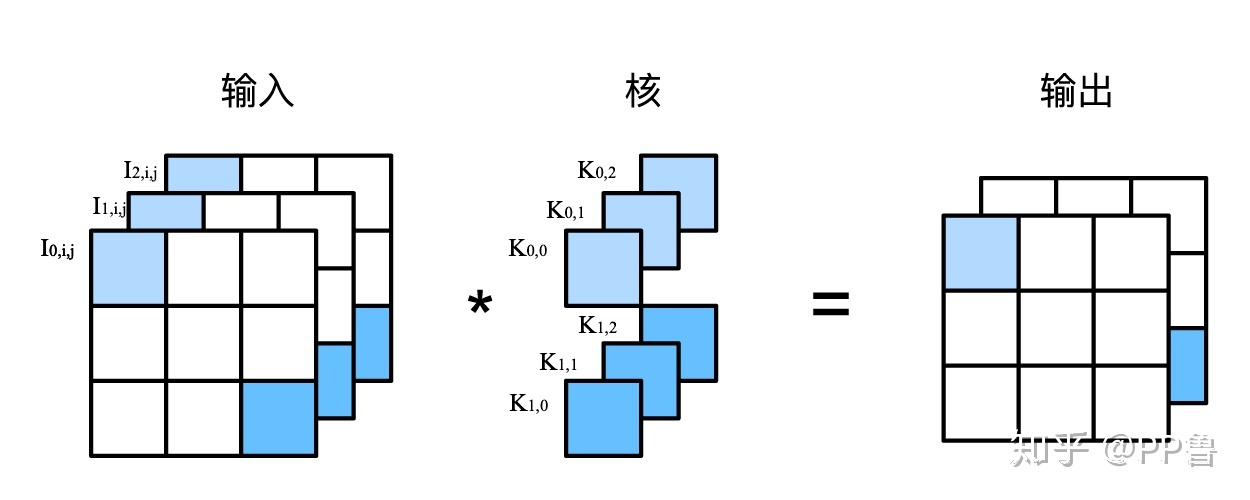
   

In [4]:
def nin_block(num_channels,kernel_size,strides,padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels,kernel_size,strides,padding,activation='relu'),
           nn.Conv2D(num_channels,kernel_size=1,activation='relu'),
           nn.Conv2D(num_channels,kernel_size=1,activation='relu'))
    return blk

In [5]:
net = nn.Sequential()
net.add( # 首先是三个规范式的组织
        nin_block(num_channels=96,kernel_size=11,strides=5,padding=0),
        nn.MaxPool2D(pool_size=3,strides=2), # 都是size为3步长为2
       
        nin_block(num_channels=256,kernel_size=5,strides=1,padding=2),
        nn.MaxPool2D(pool_size=3,strides=2),
       
        nin_block(num_channels=384,kernel_size=3,strides=1,padding=1),
        nn.MaxPool2D(pool_size=3,strides=2),nn.Dropout(0.5), # 看这！Dropout层！！！
       
        nin_block(num_channels=10,kernel_size=3,strides=1,padding=1), # 标签类别数是10！！！
        nn.GlobalAvgPool2D(), # 全局平均池化层，会将窗口形状自动设置成输入的宽高。
        nn.Flatten() # 将4维的输出转成2维的输出，形状(批量大小，10)
       )

In [6]:
X = nd.random.uniform(shape=(1,1,224,224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name,'output shape:\t',X.shape)

sequential2 output shape:	 (1, 96, 43, 43)
pool0 output shape:	 (1, 96, 21, 21)
sequential3 output shape:	 (1, 256, 21, 21)
pool1 output shape:	 (1, 256, 10, 10)
sequential4 output shape:	 (1, 384, 10, 10)
pool2 output shape:	 (1, 384, 4, 4)
dropout0 output shape:	 (1, 384, 4, 4)
sequential5 output shape:	 (1, 10, 4, 4)
pool3 output shape:	 (1, 10, 1, 1)
flatten0 output shape:	 (1, 10)


In [ ]:
lr,num_epochs,batch_size,ctx = 0.1,5,128,d2l.try_gpu()
net.initialize(force_reinit=True,ctx=ctx,init = init.Xavier())
trainer = gluon.trainer(net.collect_params(),'sgd',{'learning_rate':lr})
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)
d2l.train_ch5(net,train_iter,test_iter,batch_size,trainer,ctx,num_epochs)